In [1]:
from qcm_data import QCMData
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.ndimage import uniform_filter, gaussian_filter
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [2]:
data = QCMData.import_hdf('data/Z-230203B.h5', 'data')

In [3]:
qcm = data.extract_rotations('s1', limits=(np.deg2rad(270), np.deg2rad(390)))

dqcm = np.diff(qcm)
mins = find_peaks(-dqcm)[0]
bgd = interp1d(mins, dqcm[mins], 'linear', fill_value='extrapolate')(np.arange(dqcm.size))

maxs = find_peaks(dqcm)[0]
maxs = maxs[dqcm[maxs] > 0.8 * (np.max(dqcm) - np.min(dqcm)) + np.min(dqcm)]
period = (maxs[1:] - maxs[:-1]).mean()

sgn = period * uniform_filter(dqcm - bgd, period, mode='nearest')

In [34]:
sgn.size, factors.size

(11386, 135768)

In [29]:
factors = pd.read_hdf('data/Z-230307B.h5', 'data')['Mag3 [QCM,S1 factor] (None)'].to_numpy()

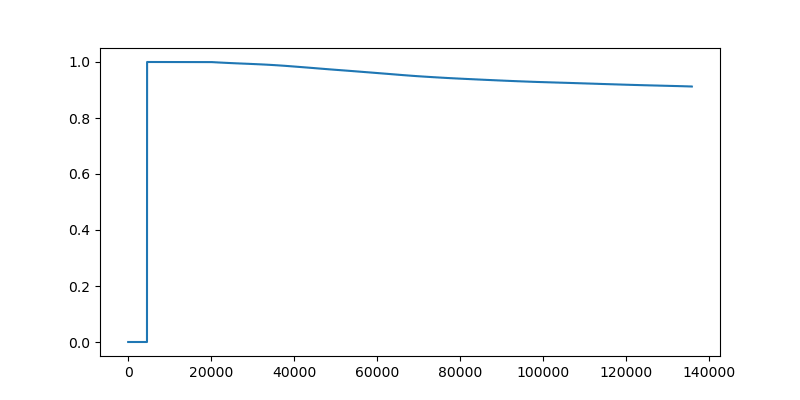

In [31]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(factors)
plt.show()

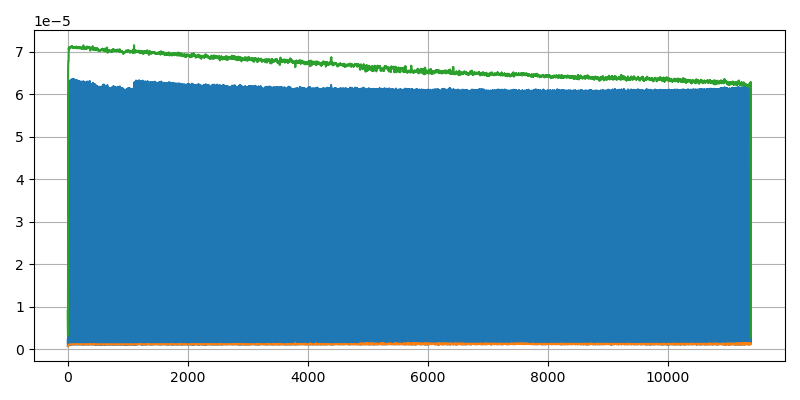

In [20]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.arange(dqcm.size), dqcm)
ax.plot(np.arange(bgd.size), bgd)
ax.plot(np.arange(sgn.size), sgn)
ax.grid(True)

fig.tight_layout()
plt.show()

In [5]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller, acf

print(adfuller(sgn))
print(adfuller(np.diff(sgn, 1)))

(1.1350127961442116, 0.9955046387698985, 21, 11364, {'1%': -3.430925570022511, '5%': -2.861794371074457, '10%': -2.566905396619508}, -293974.70549214876)
(-7.233223451968675, 1.9697534747204094e-10, 20, 11364, {'1%': -3.430925570022511, '5%': -2.861794371074457, '10%': -2.566905396619508}, -293948.2731318184)


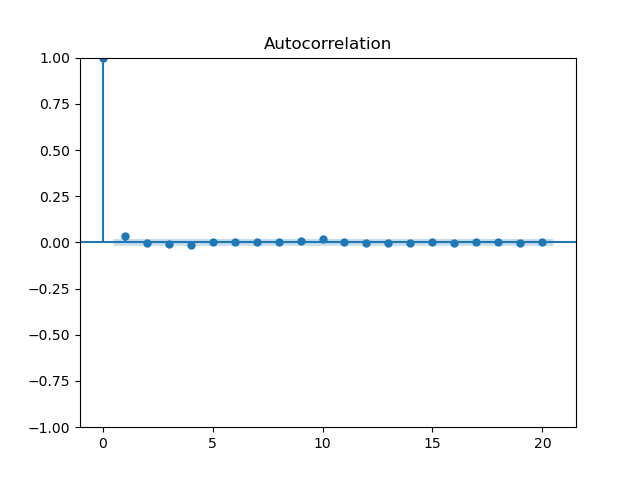

In [6]:
%matplotlib widget
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(np.diff(sgn, 1), lags=20)
plt.show()

# Robust smoothing

In [15]:
from robust_holt_winters import robust_holt_winters
import jax
import jax.numpy as jnp
import optax as ox

# decay = 0.001
# lambda1, lambda2, lambda_sigma = decay, decay, decay

lambda1, lambda2, lambda_sigma = jax.nn.sigmoid(thetas[-1])
# lambda1 *= 0.5

smoother = robust_holt_winters(lambda1=lambda1, lambda2=lambda2, lambda_sigma=lambda_sigma)

@jax.jit
def step(state, new):
    elem, state = smoother.update(new, state)
    return state, jnp.array([elem, state.sigma])

In [16]:
key = jax.random.PRNGKey(42)
warmup, samples = jnp.array(sgn[100:400]), jnp.array(sgn[400:-50])

n_outliers = 1000
std = jnp.std(samples)
idxs = jax.random.randint(key, (n_outliers,), 0, samples.size)
samples.at[idxs].set(samples[idxs] + 50 * std * jax.random.normal(key, (n_outliers,)))

state = smoother.init(warmup)

state, series = jax.lax.scan(step, smoother.init(warmup), samples)

idxs = jnp.arange(-len(samples), 0) + 1
offsets = jax.vmap(jnp.multiply, (None, 0))(state.moment, idxs)
predictions = state.last + offsets
loss = (1 - lambda1) ** -idxs * ox.huber_loss((samples - predictions) / series[:, 1])

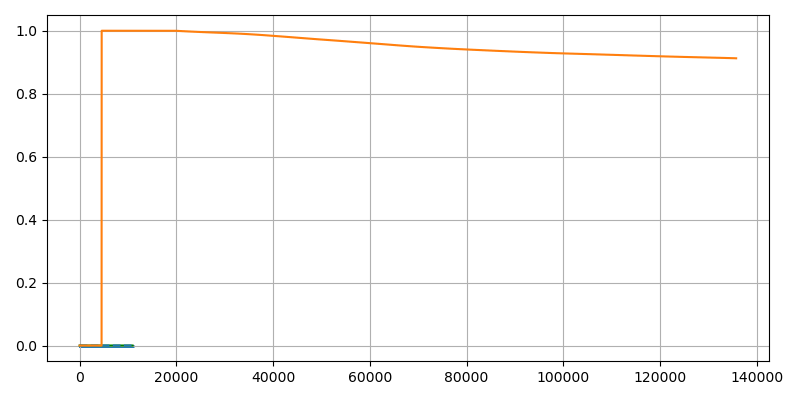

In [32]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(jnp.arange(samples.size), samples, s=0.3, alpha=0.5)

ax.plot(series[:, 0], color='g')
ax.plot(predictions, linestyle='dashed')
ax.fill_between(jnp.arange(series.shape[0]), series[:, 0] - series[:, 1],
                series[:, 0] + series[:, 1], color='r', alpha=0.5)

ax.plot(factors)

ax.grid(True)
fig.tight_layout()
plt.show()

In [12]:
from robust_holt_winters import inject_hyperparams, InjectHyperparamsState, Series

init_decay = 0.001
smoother = inject_hyperparams(robust_holt_winters)(lambda1=init_decay, lambda2=init_decay, lambda_sigma=init_decay)
opt = ox.inject_hyperparams(ox.adam)(learning_rate=ox.cosine_onecycle_schedule(2000, 3e-3))

@jax.jit
def inner_step(state, new):
    elem, state = smoother.update(new, state)
    return state, jnp.array([elem, state.inner_state.sigma])

@jax.jit
def loss(theta: jnp.ndarray, state: InjectHyperparamsState, train: Series, test: Series):
    lambda1, lambda2, lambda_sigma = jax.nn.sigmoid(theta)
    state.hyperparams.update(lambda1=lambda1, lambda2=lambda2, lambda_sigma=lambda_sigma)

    state, _ = jax.lax.scan(inner_step, state, train)
    idxs = jnp.arange(1, len(test) + 1)
    offsets = jax.vmap(jnp.multiply, (None, 0))(state.inner_state.moment, idxs)
    predictions = state.inner_state.last + offsets
    loss = ox.huber_loss((test - predictions) / state.inner_state.sigma) * state.inner_state.sigma + state.inner_state.sigma

    return jnp.sum(loss), (theta, state)

@jax.jit
def meta_step(theta: jnp.ndarray, opt_state: ox.OptState, state: InjectHyperparamsState, train: Series, test: Series):
    (value, (theta, state)), grad = jax.value_and_grad(loss, has_aux=True)(theta, state, train, test)

    updates, opt_state = opt.update(grad, opt_state)
    theta = ox.apply_updates(theta, updates)

    return value, theta, opt_state, state

In [13]:
from tqdm.auto import tqdm

series = sgn[100:-100]
theta = jnp.full(3, -jnp.log(1 / init_decay - 1))
opt_state = opt.init(theta)

N_warmup, N_train, N_test = 300, 1200, 300
key = jax.random.PRNGKey(42)
criteria, thetas = [], []

for i in tqdm(range(2000)):
    idx = jax.random.randint(key, (1,), N_warmup, series.size - N_train - N_test)[0]
    state = smoother.init(series[idx - N_warmup:idx])
    crit, theta, opt_state, state = meta_step(theta, opt_state, state, series[idx:idx + N_train],
                                              series[idx + N_train:idx + N_train + N_test])
    criteria.append(crit)
    thetas.append(theta)

  0%|          | 0/2000 [00:00<?, ?it/s]

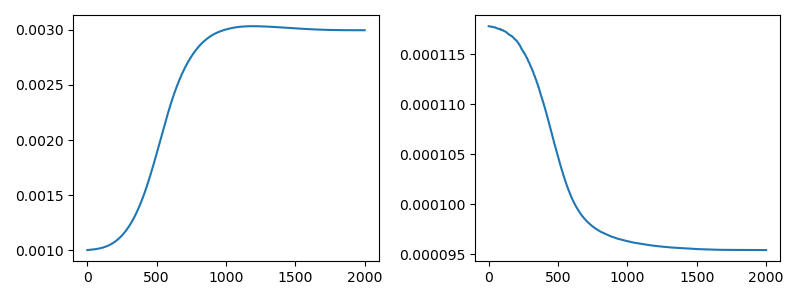

In [14]:
%matplotlib widget
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(jax.nn.sigmoid(jnp.stack(thetas)[:, 0]))
ax[1].plot(criteria)
fig.tight_layout()
plt.show()